In [ ]:
#!pip install helical==0.0.1a23
#!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of gtfparse to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of gtfparse to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to

In [ ]:
from helical.utils import get_anndata_from_hf_dataset
from helical import GeneformerConfig, GeneformerFineTuningModel, scGPTConfig, scGPTFineTuningModel
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import logging, warnings
import umap
import pandas as pd
import seaborn as sns
import scanpy as sc
import os
import gdown
import anndata as ad
from datasets import load_dataset

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:datasets:PyTorch version 2.5.1+cu124 available.
INFO:datasets:Polars version 1.21.0 available.
INFO:datasets:TensorFlow version 2.18.0 available.
INFO:datasets:JAX version 0.4.33 available.
INFO:helical:Caduceus not available: If you want to use this model, ensure you have a CUDA GPU and have installed the optional helical[mamba-ssm] dependencies.


# Datos Helical

In [ ]:
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, download_mode="reuse_cache_if_exists")

train_dataset = get_anndata_from_hf_dataset(ds["train"])
test_dataset = get_anndata_from_hf_dataset(ds["test"])

cell_types_train = list(np.array(train_dataset.obs["LVL3"].tolist())) # Cambiar niveles LVL2, LVL3
cell_types_test = list(np.array(test_dataset.obs["LVL3"].tolist()))

label_set = set(cell_types_train) | set(cell_types_test)
class_id_dict = dict(zip(label_set, [i for i in range(len(label_set))]))
id_class_dict = {v: k for k, v in class_id_dict.items()}


#Sustituimos los enteros por sus identificadores numéricos
for i in range(len(cell_types_train)):
    cell_types_train[i] = class_id_dict[cell_types_train[i]]

for i in range(len(cell_types_test)):
    cell_types_test[i] = class_id_dict[cell_types_test[i]]

y_true_train = train_dataset.obs["LVL3"].astype('category').cat.codes.to_numpy()
y_true_test = test_dataset.obs["LVL3"].astype('category').cat.codes.to_numpy()

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Datos Esclerosis Múltiple

In [ ]:
output_dir = "../data/ms"
if os.path.exists(output_dir):

    print("data already downloaded!!")

else:

    folder_id = "1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v"
    gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", output=output_dir, quiet=False)

Retrieving folder contents


Processing file 1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi c_data.h5ad
Processing file 1casFhq4InuBNhJLMnGebzkRXM2UTTeQG filtered_ms_adata.h5ad
Processing file 1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl .DS_Store


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1bV1SHKVZgkcL-RmmuN51_IIUJTSJbXOi
To: /data/ms/c_data.h5ad
100%|██████████| 20.6M/20.6M [00:00<00:00, 86.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1casFhq4InuBNhJLMnGebzkRXM2UTTeQG
To: /data/ms/filtered_ms_adata.h5ad
100%|██████████| 47.1M/47.1M [00:00<00:00, 54.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Vp51xYAOEu5_Wd7lilnatvMJ7tr2bsbl
To: /data/ms/.DS_Store
100%|██████████| 6.15k/6.15k [00:00<00:00, 12.1MB/s]
Download completed


In [ ]:
data_train = ad.read_h5ad(f'../data/ms/c_data.h5ad')
data_test = ad.read_h5ad(f'../data/ms/filtered_ms_adata.h5ad')

data_test.var = data_test.var.set_index('gene_name')
data_test.var["gene_name"] = data_test.var.index

cell_types_train = list(np.array(data_train.obs["celltype"].tolist()))
cell_types_test = list(np.array(data_test.obs["celltype"].tolist()))

label_set = set(cell_types_train) | set(cell_types_test) # Unimos ambos conjuntos
class_id_dict = dict(zip(label_set, [i for i in range(len(label_set))]))
id_class_dict = {v: k for k, v in class_id_dict.items()}


#Sustituimos los enteros por sus identificadores numéricos
for i in range(len(cell_types_train)):
    cell_types_train[i] = class_id_dict[cell_types_train[i]]

for i in range(len(cell_types_test)):
    cell_types_test[i] = class_id_dict[cell_types_test[i]]

# Modelo scGPT

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
scgpt_config=scGPTConfig(batch_size=16, device=device) # Batch_size limitado por capacidades de memoria
scgpt_fine_tune = scGPTFineTuningModel(scGPT_config=scgpt_config, fine_tuning_head="classification", output_size=len(label_set))

INFO:helical.utils.downloader:Creating Folder /root/.cache/helical/models/scgpt/scGPT_CP
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/scgpt/scGPT_CP/vocab.json'
Downloading: 100%|██████████| 1.32M/1.32M [00:00<00:00, 6.39MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/scgpt/scGPT_CP/vocab.json'
INFO:helical.utils.downloader:File does not exist or has incorrect hash. Starting to download: 'https://helicalpackage.blob.core.windows.net/helicalpackage/data/scgpt/scGPT_CP/best_model.pt'
Downloading: 100%|██████████| 208M/208M [00:02<00:00, 74.4MB/s]
INFO:helical.utils.downloader:File saved to: '/root/.cache/helical/models/scgpt/scGPT_CP/best_model.pt'
INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cls'.


## Aplicado a Datos Esclerosis Múltiple

In [ ]:
dataset = scgpt_fine_tune.process_data(data_train, gene_names = "gene_name", use_raw_counts=False, fine_tuning=True)
validation_dataset = scgpt_fine_tune.process_data(data_test, gene_names = "gene_name", use_raw_counts=False, fine_tuning=True)

INFO:helical.models.scgpt.model:Processing data for scGPT.


INFO:helical.models.scgpt.model:Filtering out 109 genes to a total of 1691 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Processing data for scGPT.


INFO:helical.models.scgpt.model:Filtering out 99 genes to a total of 1701 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.


In [ ]:
scgpt_fine_tune.train(train_input_data=dataset, train_labels=cell_types_train, validation_input_data=validation_dataset, validation_labels=cell_types_test, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

INFO:helical.models.scgpt.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 842/842 [01:55<00:00,  7.30it/s, val_loss=1.04]
INFO:helical.models.scgpt.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


In [ ]:
outputs_scm_train = scgpt_fine_tune.get_outputs(dataset)
outputs_scm_test = scgpt_fine_tune.get_outputs(validation_dataset)

embeddings_scm_train = scgpt_fine_tune.get_embeddings(dataset)
embeddings_scm_test = scgpt_fine_tune.get_embeddings(validation_dataset)

y_pred_test = outputs_scm_test.argmax(axis=1)

Fine-Tuning Validation: 100%|██████████| 842/842 [01:47<00:00,  7.82it/s]
INFO:helical.models.scgpt.model:Started getting embeddings:
Embedding cells: 100%|██████████| 491/491 [00:26<00:00, 18.52it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.
INFO:helical.models.scgpt.model:Started getting embeddings:
Embedding cells: 100%|██████████| 842/842 [00:51<00:00, 16.24it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


In [ ]:
print("-----Resultados Train-----")
print(classification_report(cell_types_train,outputs_scm_train.argmax(axis=1)))

print("-----Resultados Test-----")
print(classification_report(cell_types_test,outputs_scm_test.argmax(axis=1)))

-----Resultados Train-----
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       662
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.94      0.96      0.95       569
           4       0.00      0.00      0.00       114
           5       0.96      0.05      0.10       413
           6       0.94      0.39      0.56        38
           7       0.89      0.91      0.90       234
           8       0.83      0.82      0.83        55
           9       0.91      0.95      0.93       154
          10       0.71      0.20      0.31        60
          11       0.66      1.00      0.80        53
          12       0.91      0.81      0.86      1284
          13       0.00      0.00      0.00      1019
          14       0.58      0.97      0.72      2010
          15       0.85      0.91      0.88       172
          16       0.70      0.93      0.80       997


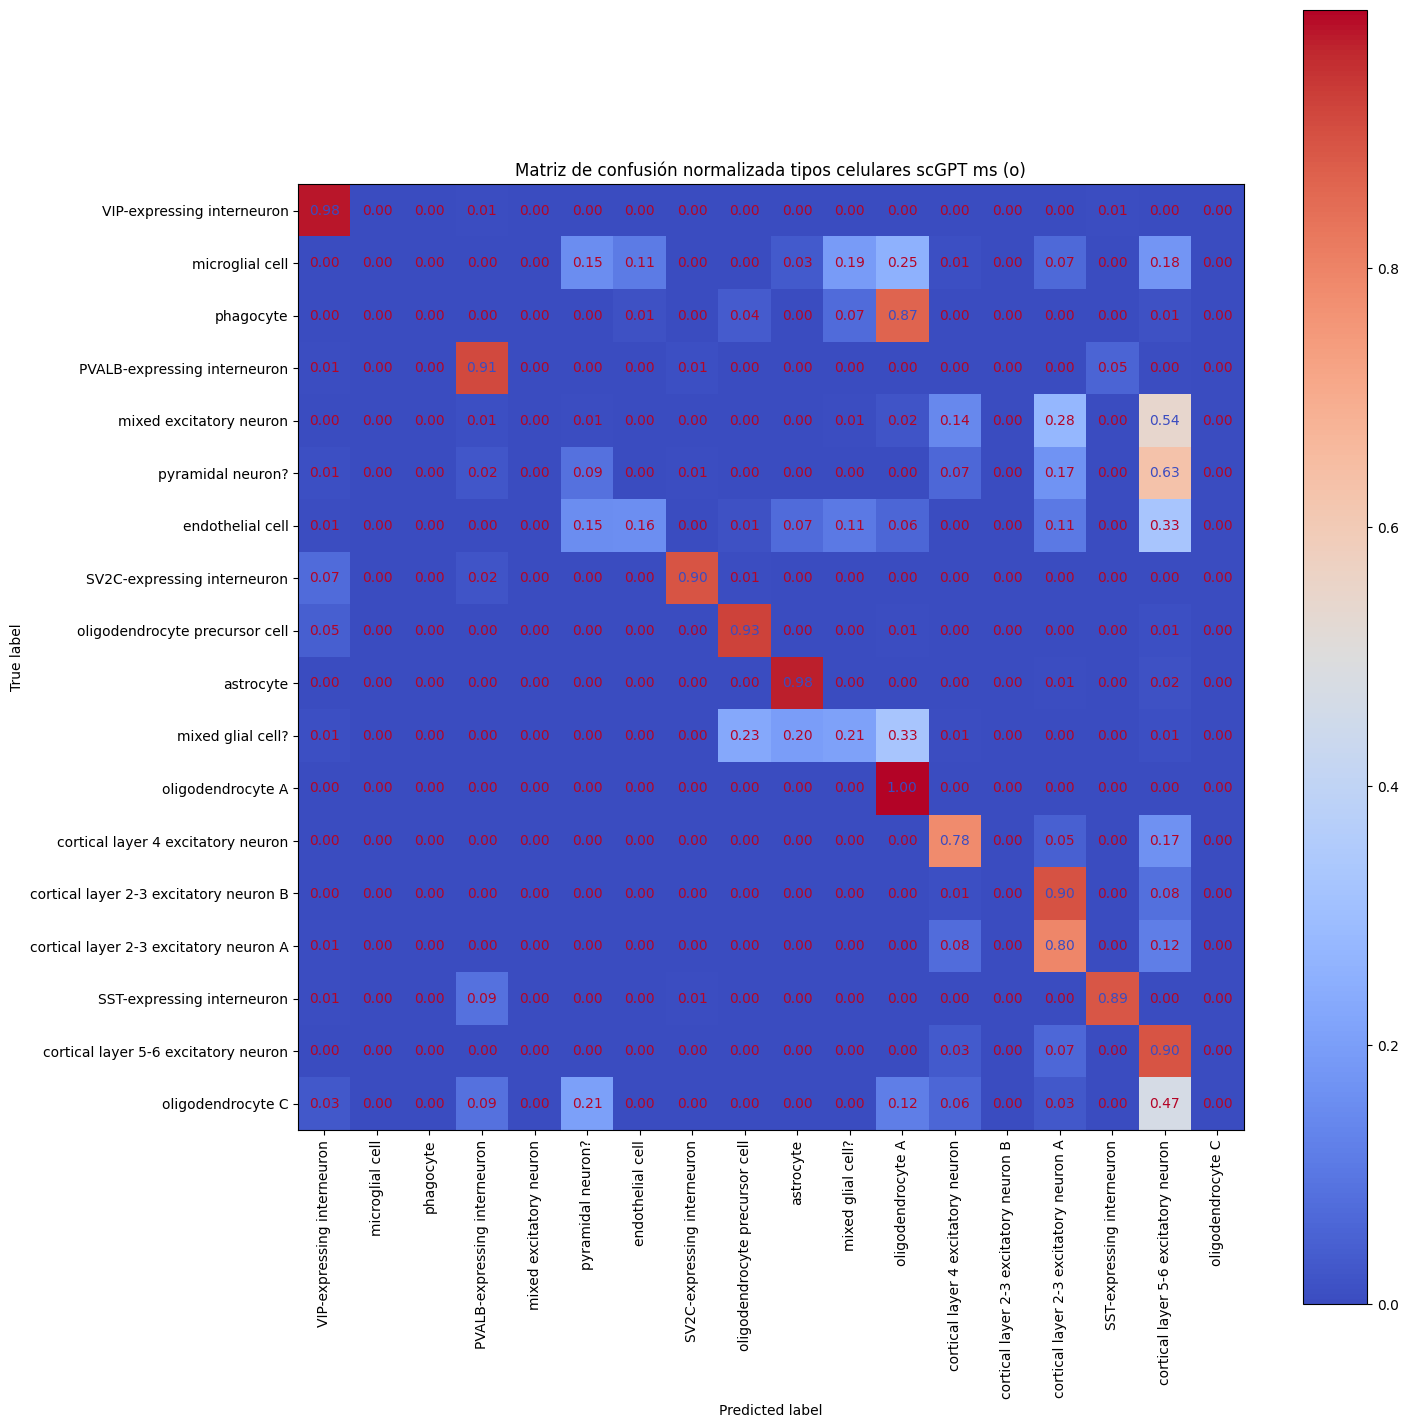

In [ ]:
cm = confusion_matrix(cell_types_test, outputs_scm_test.argmax(axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = np.unique(np.concatenate((cell_types_test, outputs_scm_test.argmax(axis=1))))

class_names = [id_class_dict[label] for label in unique_labels]

fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

ax.set_title('Matriz de confusión normalizada tipos celulares scGPT ms (o)')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

## Aplicado a Datos Helical

In [ ]:
dataset = scgpt_fine_tune.process_data(train_dataset, gene_names = "gene_name", n_top_genes=3000, fine_tuning=True)
validation_dataset = scgpt_fine_tune.process_data(test_dataset, gene_names = "gene_name",n_top_genes=3000, fine_tuning=True)

INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 954 genes to a total of 2046 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Processing data for scGPT.
INFO:helical.models.scgpt.model:Filtering out 789 genes to a total of 2211 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.


In [ ]:
scgpt_fine_tune.train(train_input_data=dataset, train_labels=cell_types_train, validation_input_data=validation_dataset, validation_labels=cell_types_test, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

INFO:helical.models.scgpt.fine_tuning_model:Starting Fine-Tuning
Fine-Tuning Validation: 100%|██████████| 396/396 [01:09<00:00,  5.71it/s, val_loss=0.428]
INFO:helical.models.scgpt.fine_tuning_model:Fine-Tuning Complete. Epochs: 1


In [ ]:
outputs_sch_train = scgpt_fine_tune.get_outputs(dataset)
outputs_sch_test = scgpt_fine_tune.get_outputs(validation_dataset)

embeddings_sch_train = scgpt_fine_tune.get_embeddings(dataset)
embeddings_sch_test = scgpt_fine_tune.get_embeddings(validation_dataset)

y_pred_test_h = outputs_sch_test.argmax(axis=1)

Fine-Tuning Validation: 100%|██████████| 396/396 [01:03<00:00,  6.24it/s]
INFO:helical.models.scgpt.model:Started getting embeddings:
Embedding cells: 100%|██████████| 1584/1584 [01:30<00:00, 17.57it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.
INFO:helical.models.scgpt.model:Started getting embeddings:
Embedding cells: 100%|██████████| 396/396 [00:30<00:00, 13.17it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


In [ ]:
print("-----Resultados Train-----")
print(classification_report(cell_types_train,outputs_sch_train.argmax(axis=1)))

print("-----Resultados Test-----")
print(classification_report(cell_types_test,outputs_sch_test.argmax(axis=1)))

-----Resultados Train-----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.96      0.23      0.37       681
           2       0.00      0.00      0.00         2
           3       0.86      0.60      0.71        10
           4       0.91      0.98      0.94       167
           5       0.88      0.82      0.85        44
           6       0.28      0.00      0.01      1137
           7       0.00      0.00      0.00       159
           8       0.00      0.00      0.00       937
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        12
          13       0.25      0.02      0.04        46
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00        11


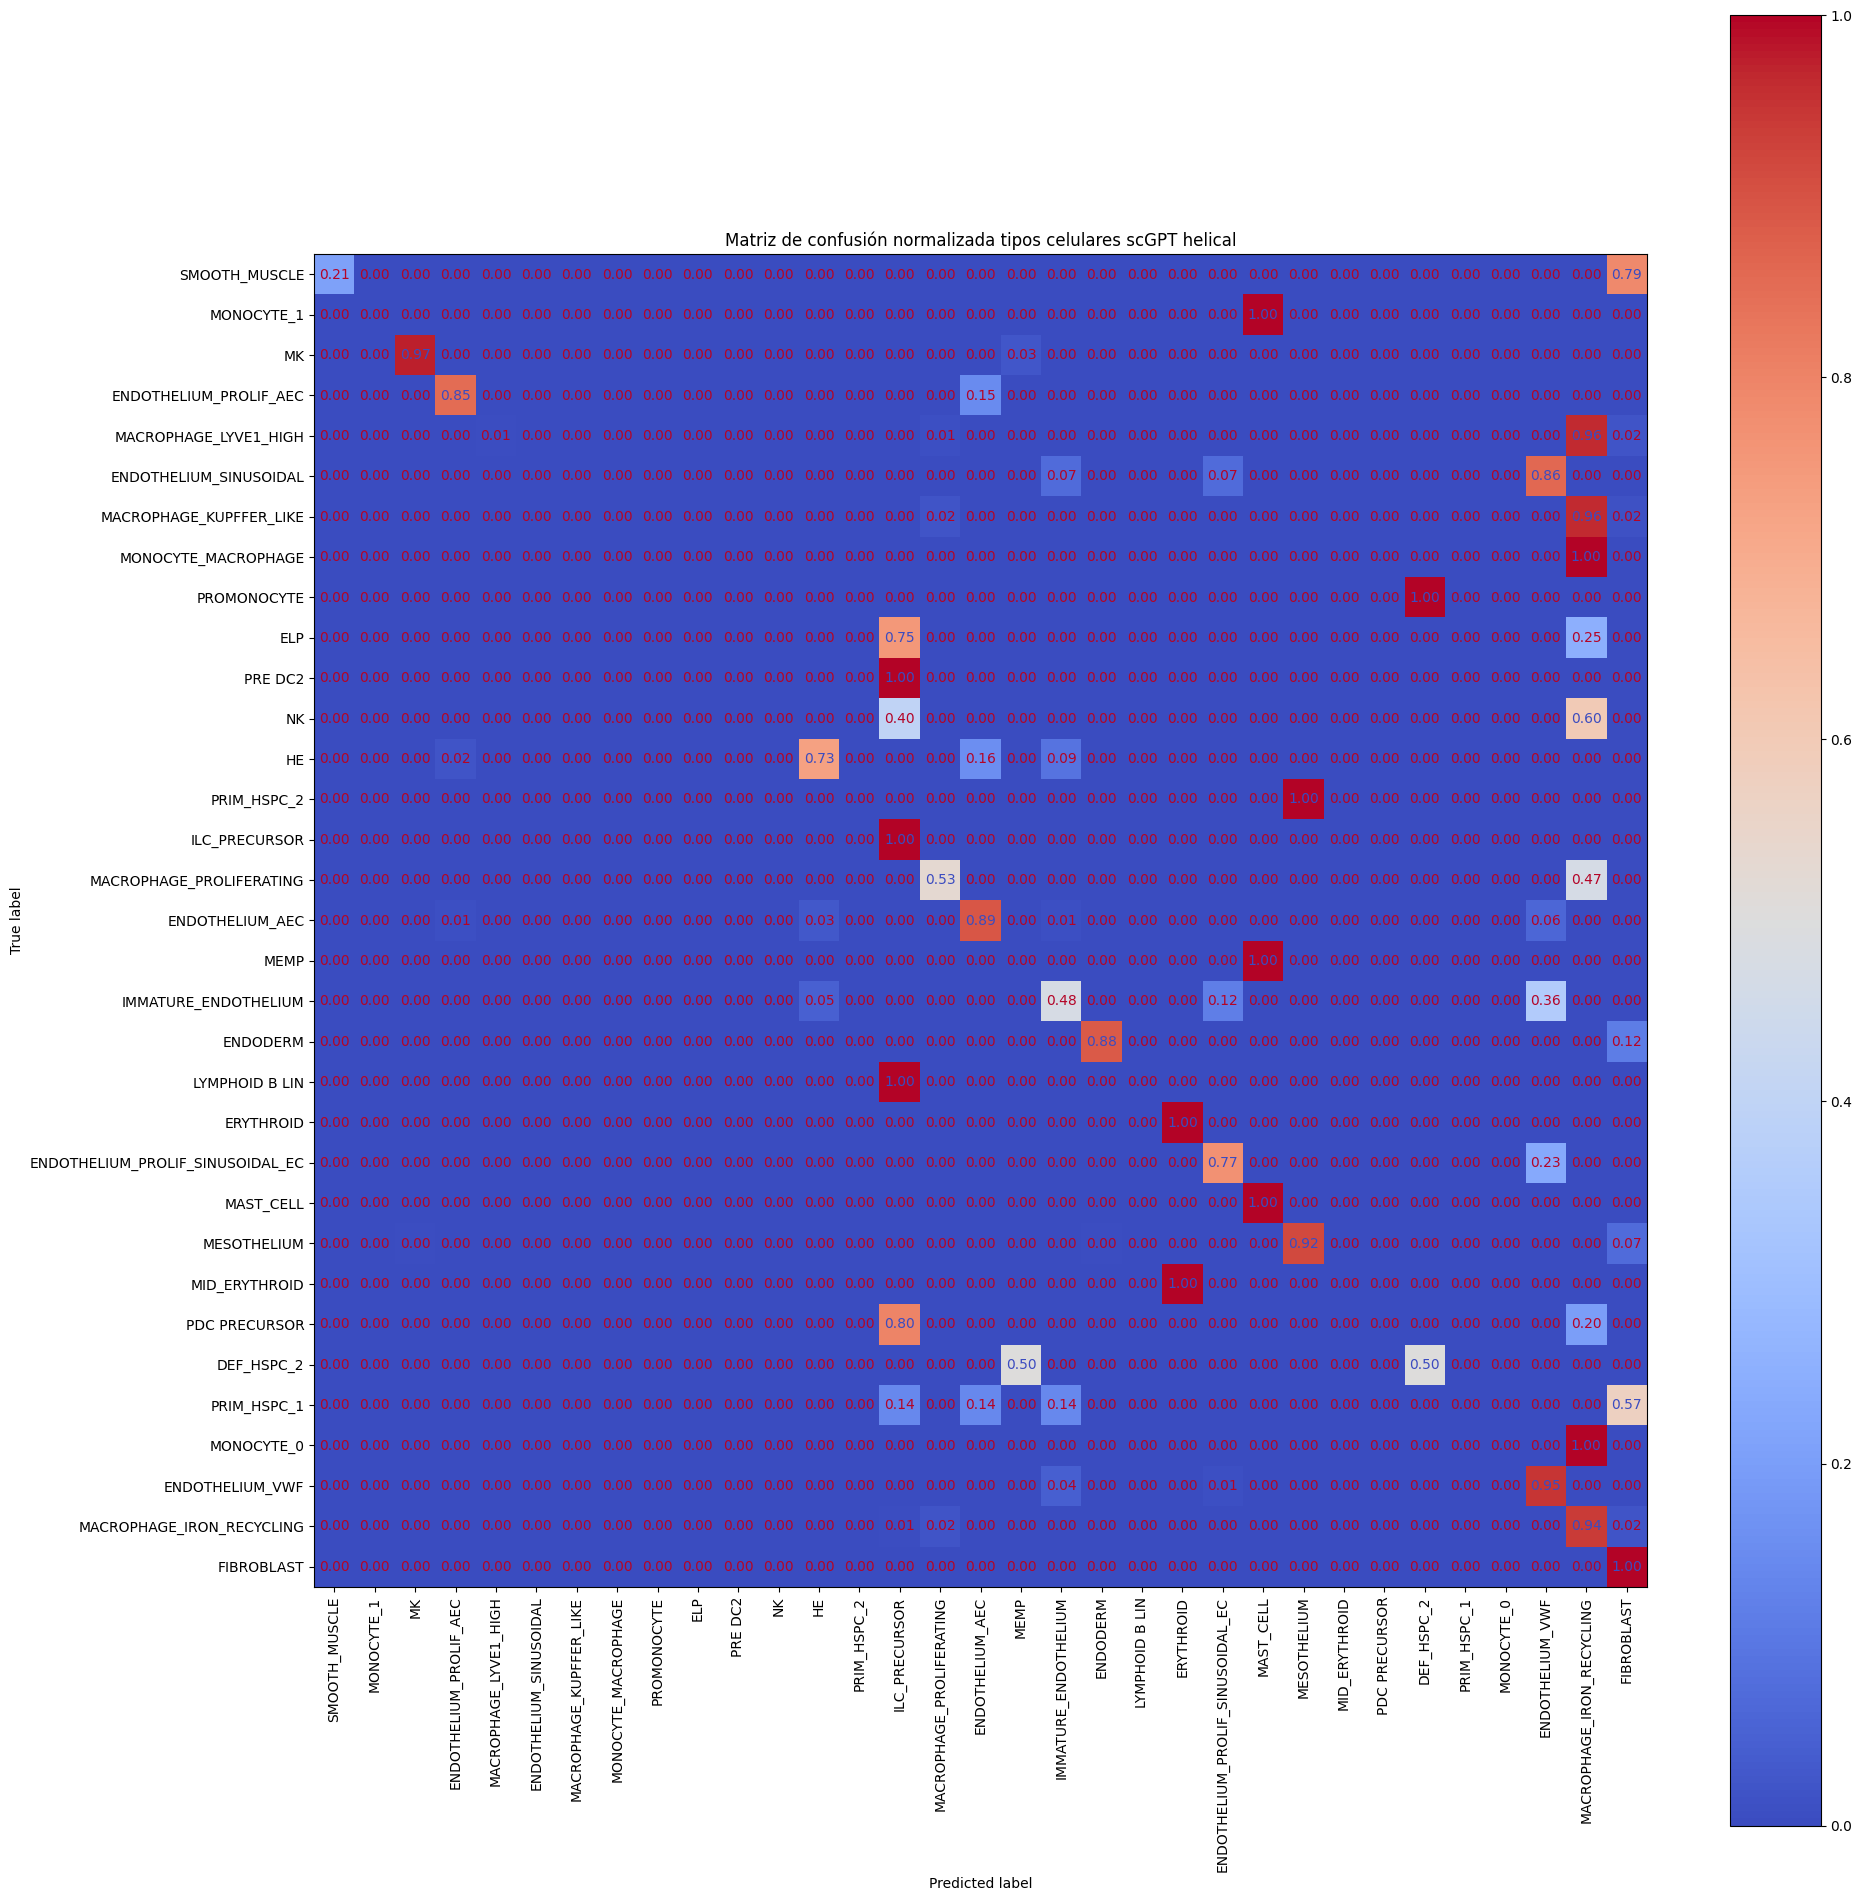

In [ ]:
cm = confusion_matrix(cell_types_test, outputs_sch_test.argmax(axis=1))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

unique_labels = np.unique(np.concatenate((cell_types_test, outputs_sch_test.argmax(axis=1))))

class_names = [id_class_dict[label] for label in unique_labels]

fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

ax.set_title('Matriz de confusión normalizada tipos celulares scGPT helical')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

## Visualización de Embeddings Fine-tuned scGPT

### Datos Esclerosis

Text(0.5, 1.0, 'UMAP of scGPT fine-tuned embeddings by cell types ground-truth labels')

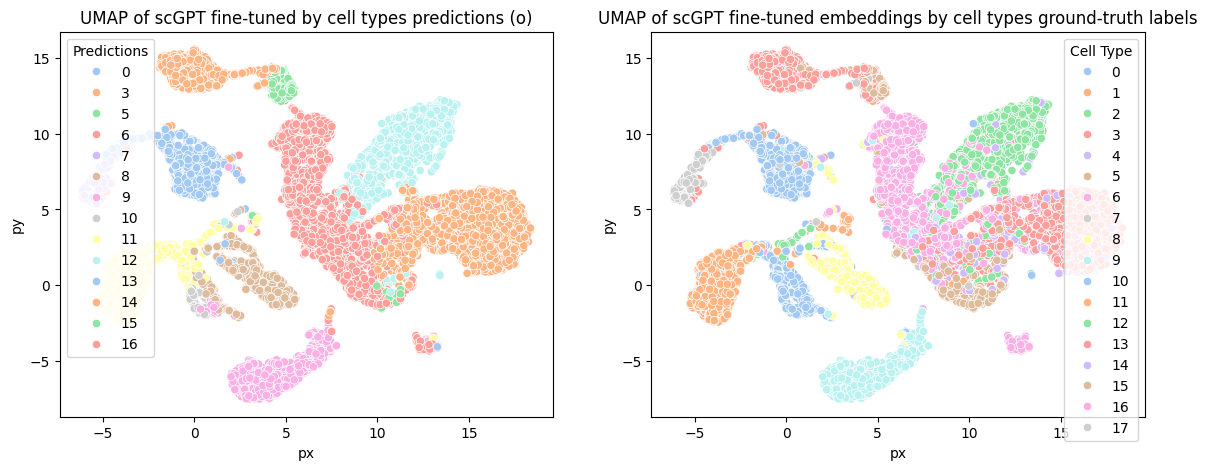

In [ ]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None, n_neighbors=4)
mapper = reducer.fit(embeddings_scm_test_o)

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
# Modificar para incluir otros detalles
labels = cell_types_test
plot_df['Cell Type'] = labels
plot_df['Predictions'] = y_pred_test_o


# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.scatterplot(data = plot_df,x='px',y='py',hue='Predictions',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of scGPT fine-tuned by cell types predictions (o)')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of scGPT fine-tuned embeddings by cell types ground-truth labels')

In [ ]:
embeddings_test = ad.AnnData(X=embeddings_scm_test)
data_test_o.obsm["X_scgpt"] = embeddings_test.X

sc.tl.pca(embeddings_test)
data_test.obsm["X_pca"] = embeddings_test.obsm['X_pca']
data_test.uns["pca"] = embeddings_test.uns['pca']
data_test.varm['PCs'] = embeddings_test.varm['PCs']

sc.pp.neighbors(embeddings_test, use_rep="X")
sc.tl.umap(embeddings_test, random_state = 0)

data_test.obsm["X_umap"] = embeddings_test.obsm["X_umap"]
data_test.uns["neighbors"] = embeddings_test.uns['neighbors']
data_test.obsp["distances"] = embeddings_test.obsp['distances']
data_test.obsp["connectivities"] = embeddings_test.obsp['connectivities']
data_test.obs["Preds"] = y_pred_test

sc.tl.tsne(data_test, use_rep = "X_pca", random_state = 0)

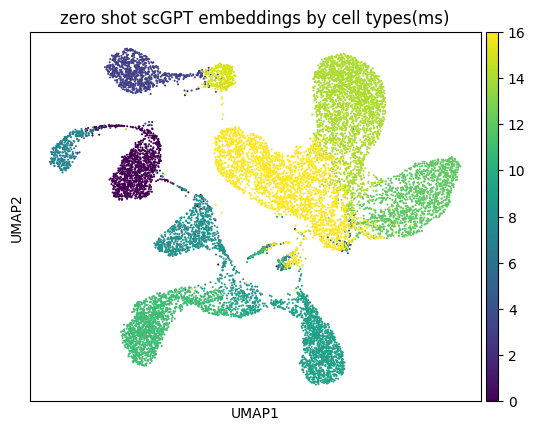

In [ ]:
sc.pl.umap(data_test, color=["Preds"], wspace = 0.6,title = "Fine tuned scGPT embeddings by cell types predictions(ms)")

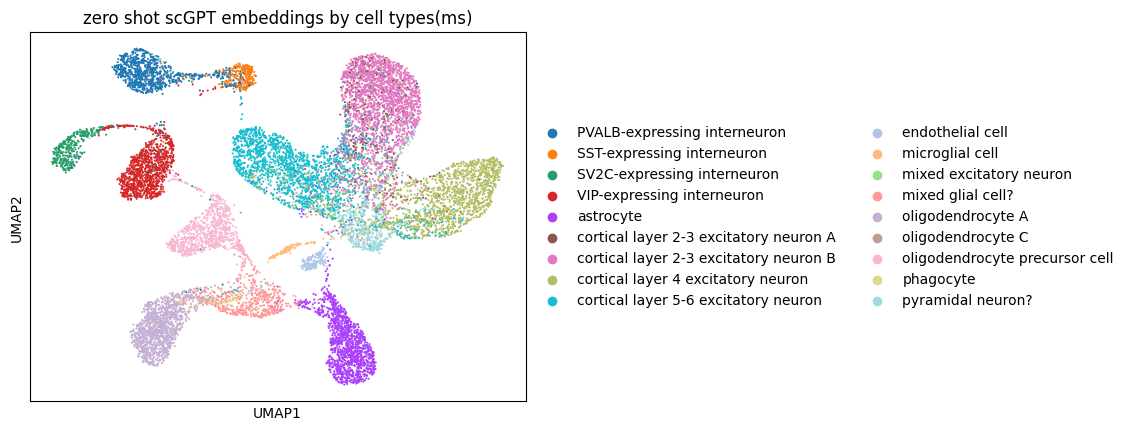

In [ ]:
sc.pl.umap(data_test, color=["celltype"], wspace = 0.6,title = "Fine tuned scGPT embeddings by cell types ground-truth(ms)")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
sc.pl.tsne(data_test, color='celltype', ax=ax1, show=False, title='t-SNE scGPT fine-tuned embeddings ms', legend_fontsize=8)
sc.pl.umap(data_test, color='celltype', ax=ax2, show=False, title='UMAP scGPT fine-tuned embeddings ms', legend_fontsize=8)

plt.tight_layout()
plt.show()

### Datos Helical

In [ ]:
embeddings_test = ad.AnnData(X=embeddings_sch_test)
test_dataset.obsm["X_scgpt"] = embeddings_test.X


sc.tl.pca(embeddings_test)
test_dataset.obsm["X_pca"] = embeddings_test.obsm['X_pca']
test_dataset.uns["pca"] = embeddings_test.uns['pca']

sc.pp.neighbors(embeddings_test, use_rep="X")
sc.tl.umap(embeddings_test)

test_dataset.obsm["X_umap"] = embeddings_test.obsm["X_umap"]
test_dataset.uns["neighbors"] = embeddings_test.uns['neighbors']
test_dataset.obsp["distances"] = embeddings_test.obsp['distances']
test_dataset.obsp["connectivities"] = embeddings_test.obsp['connectivities']
test_dataset.obs["Preds"] = y_pred_test_h

sc.tl.tsne(test_dataset, use_rep = "X_pca", random_state = 0)

... storing 'LVL1' as categorical
... storing 'LVL2' as categorical
... storing 'LVL3' as categorical


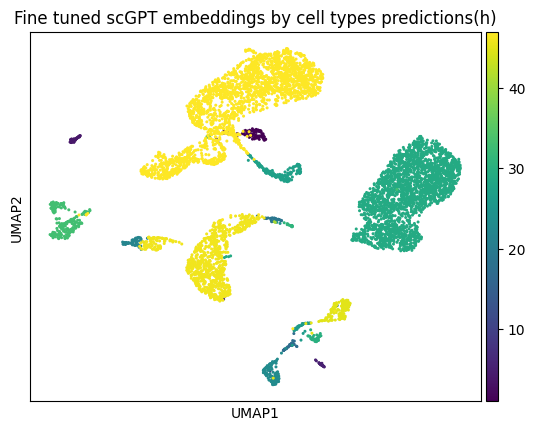

In [ ]:
sc.pl.umap(test_dataset, color=["Preds"], wspace = 0.6,title = "Fine tuned scGPT embeddings by cell types predictions(h)")

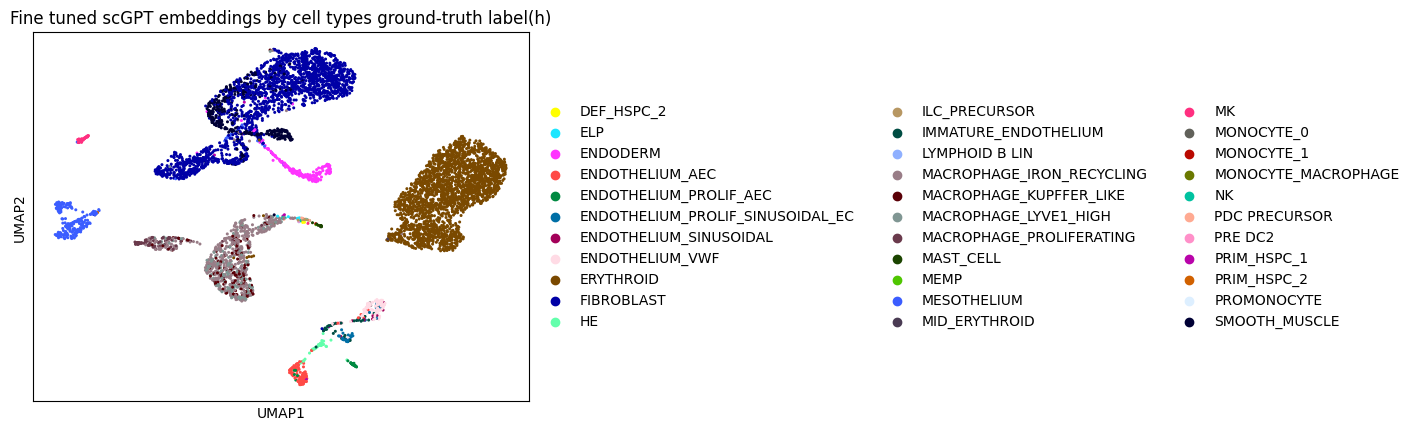

In [ ]:
sc.pl.umap(test_dataset, color=["LVL3"], wspace = 0.6,title = "Fine tuned scGPT embeddings by cell types ground-truth label(h)")

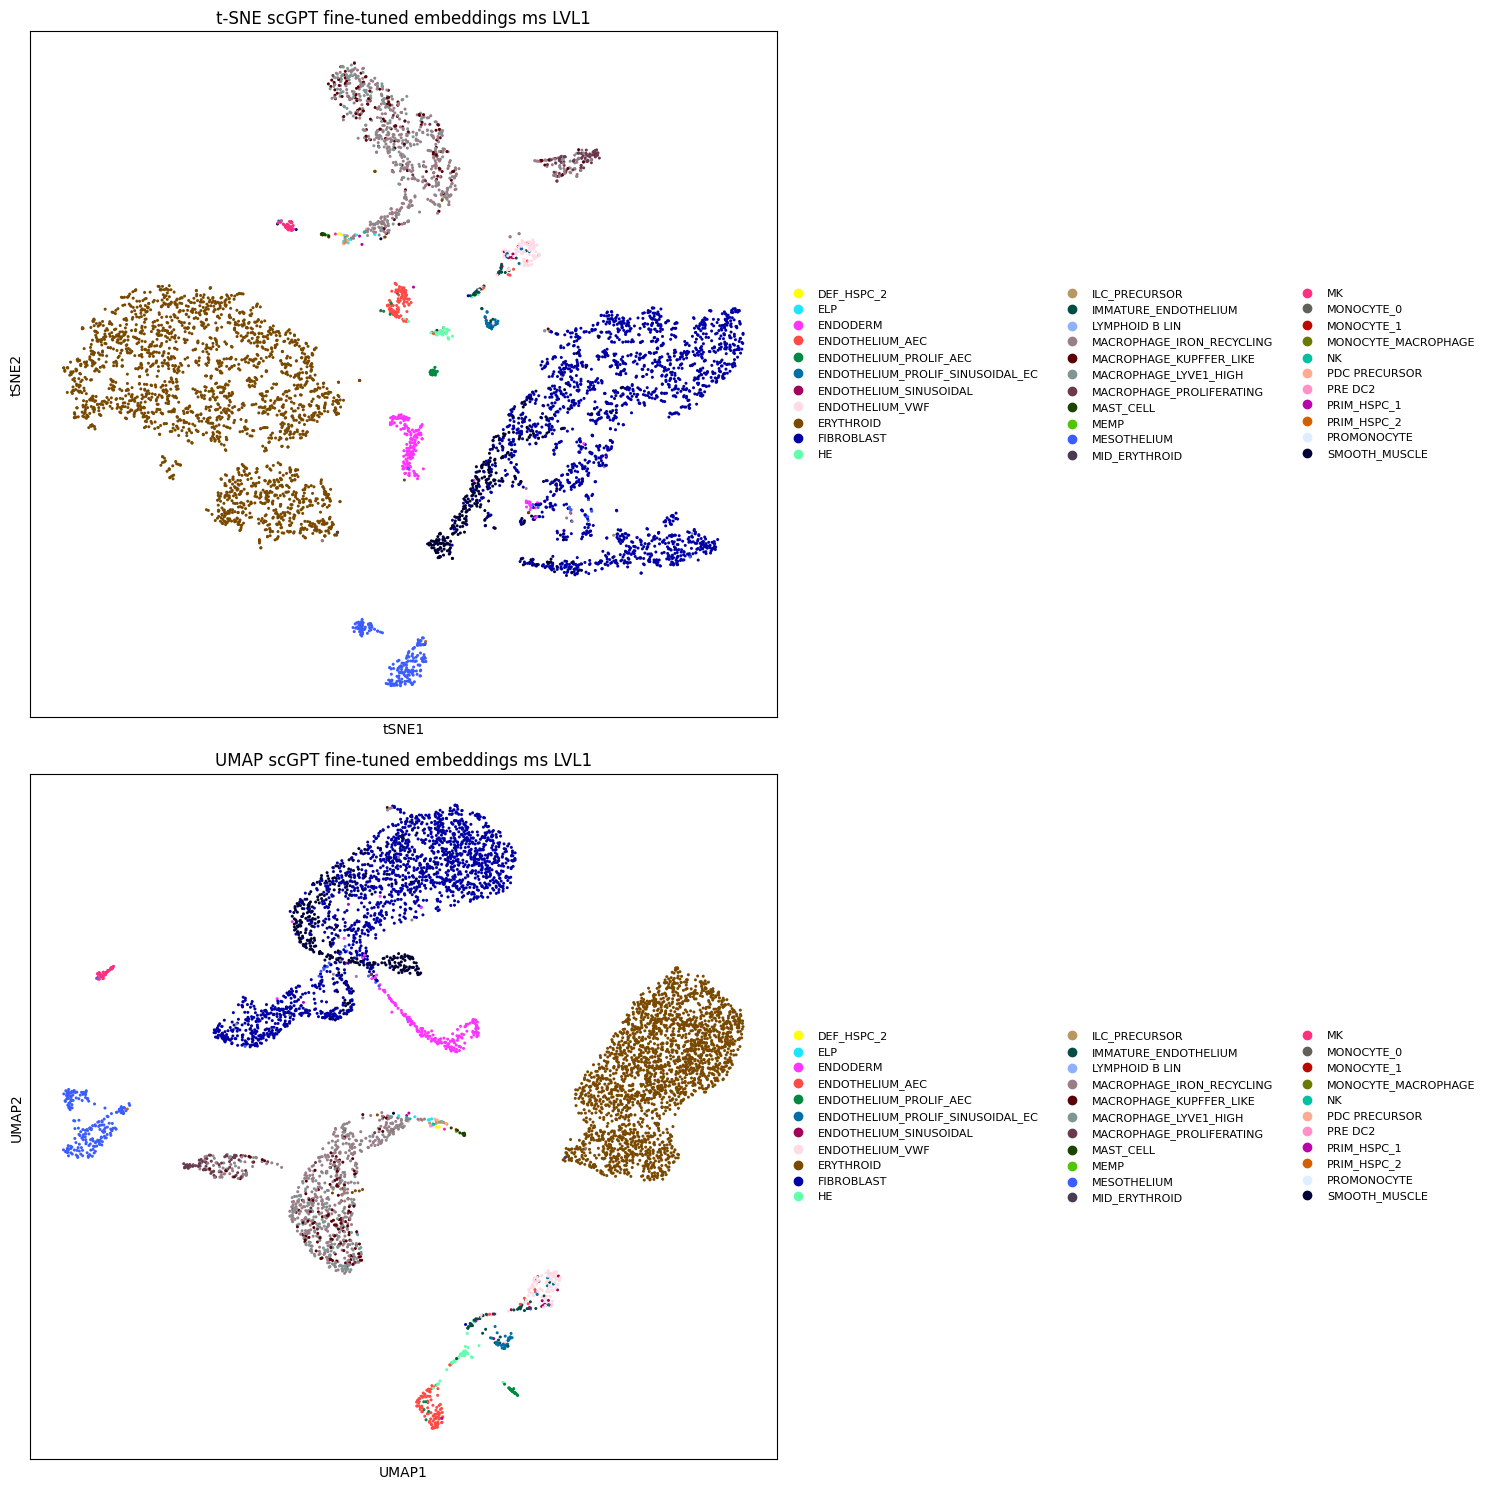

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
# Cambiar niveles de clasificación
sc.pl.tsne(test_dataset, color='LVL3', ax=ax1, show=False, title='t-SNE scGPT fine-tuned embeddings ms LVL1', legend_fontsize=8)
sc.pl.umap(test_dataset, color='LVL3', ax=ax2, show=False, title='UMAP scGPT fine-tuned embeddings ms LVL1', legend_fontsize=8)

plt.tight_layout()
plt.show()